# Customer Sentiment Using TensorFlow

Modification of Customer Sentiment Reviews_Model 2 to TensorFlow model.

Requirements:

    * tensorflow
    * sckikit-learn
    * pandas
    * Numpy (v 1.23)
    * nltk
    * re
    * seaborn
    * matplotlib

In [21]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


Current version of numpy does not work with TensorFlow, install older more compatible version

In [3]:
pip install numpy==1.23.5

Note: you may need to restart the kernel to use updated packages.


In [36]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

#### 

### Quick view of the raw data:

In [4]:
reviews = pd.read_csv('iphone.csv')
reviews.head()

,productAsin,country,date,isVerified,ratingScore,reviewTitle,reviewDescription,reviewUrl,reviewedIn,variant,variantAsin
0,B09G9BL5CP,India,11-08-2024,True,4,No charger,"Every thing is good about iPhones, there's not...",https://www.amazon.in/gp/customer-reviews/R345...,Reviewed in India on 11 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
1,B09G9BL5CP,India,16-08-2024,True,5,iPhone 13 256GB,"It look so fabulous, I am android user switche...",https://www.amazon.in/gp/customer-reviews/R2HJ...,Reviewed in India on 16 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
2,B09G9BL5CP,India,14-05-2024,True,4,Flip camera option nill,I tried to flip camera while recording but no ...,https://www.amazon.in/gp/customer-reviews/R3Y7...,Reviewed in India on 14 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
3,B09G9BL5CP,India,24-06-2024,True,5,Product,100% genuine,https://www.amazon.in/gp/customer-reviews/R1P9...,Reviewed in India on 24 June 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
4,B09G9BL5CP,India,18-05-2024,True,5,Good product,Happy to get the iPhone 13 in Amazon offer,https://www.amazon.in/gp/customer-reviews/R1XI...,Reviewed in India on 18 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98


#### 

### Clean and prepare the data

In [5]:
column_name_mapping = {'productAsin':'Product_Number','country':'Country','date':'Date',
                       'isVerified':'Verified','ratingScore':'Rating_Score','reviewTitle':'Review_Title',
                       'reviewDescription':'Review_Description','reviewUrl':'Review_Url',
                       'reviewedIn':'Reviewer_Location','variant':'Product_Type','variantAsin':'Product_Type_Number'}

reviews.rename(columns=column_name_mapping, inplace=True)

In [6]:
emojis = (r'[\U0001F600-\U0001F64F' 
        r'\U0001F300-\U0001F5FF'  
        r'\U0001F680-\U0001F6FF'  
        r'\U0001F700-\U0001F77F'  
        r'\U0001F780-\U0001F7FF'  
        r'\U0001F800-\U0001F8FF'  
        r'\U0001F900-\U0001F9FF'  
        r'\U0001FA00-\U0001FA6F'  
        r'\U0001FA70-\U0001FAFF'  
        r'\U00002764\ufe0f'  
        r']+')

# Removes emoji characters from Review_Description column
reviews['Review_Description'] = reviews['Review_Description'].apply(lambda x: re.sub(emojis, '', str(x)) if isinstance(x, str) else x)

# Asigns rating score a category of High, Low, and Neutral
reviews['Rating_Category'] = np.where(reviews['Rating_Score'] >= 4, 'High', np.where(reviews['Rating_Score'] <=2, 'Low', 'Neutral'))

In [7]:
# Asigns rating category a number
rating_mapping = {'High':1,'Low':2,'Neutral':3}
reviews['Numerical_Rating_Category'] = reviews['Rating_Category'].map(rating_mapping)

In [8]:
reviews = reviews.dropna(subset=['Review_Description']) # Drop rows with null values

#### 




### Train the model:

In [11]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2))

X = vectorizer.fit_transform(reviews['Review_Description'])

y = reviews['Numerical_Rating_Category']

# Train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [12]:
x_train_dense = X_train.toarray()
x_test_dense = X_test.toarray()

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train) # Converts labels to numbers
y_test_encoded = label_encoder.fit_transform(y_test)

In [13]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(x_train_dense.shape[1],)),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [15]:
history = model.fit(x_train_dense, y_train_encoded,
                   epochs=20,
                   batch_size=32,
                   validation_data=(x_test_dense, y_test_encoded))

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6677 - loss: 1.0516 - val_accuracy: 0.6741 - val_loss: 0.8801
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6808 - loss: 0.7825 - val_accuracy: 0.6887 - val_loss: 0.6862
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8096 - loss: 0.5154 - val_accuracy: 0.7951 - val_loss: 0.5597
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9038 - loss: 0.3215 - val_accuracy: 0.8108 - val_loss: 0.5079
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9028 - loss: 0.2469 - val_accuracy: 0.8197 - val_loss: 0.4873
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9122 - loss: 0.1928 - val_accuracy: 0.8309 - val_loss: 0.4732
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9068 - loss: 0.1669 - val_accuracy: 0.8287 - val_loss: 0.4665
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9102 - loss: 0.1521 - val_accuracy: 0.8242 - v

In [16]:
loss, accuracy = model.evaluate(x_test_dense, y_test_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8513 - loss: 0.4565
Test Loss: 0.5093
Test Accuracy: 0.8354


### Prediction:

In [17]:
def predict_customer_sentiment(review_text):
    review_tfidf = vectorizer.transform([review_text])
    
    sentiment_labels = {1:'Positive', 2:'Negative', 3:'Neutral'}
    
    sentiment_probs = model.predict(review_tfidf.toarray())
    sentiment_class = sentiment_probs.argmax(axis=1)[0]
    
    sentiment_class += 1
    
    return sentiment_labels[sentiment_class]

In [18]:
testreview1 = "I absolutely love my new iPhone!"

In [19]:
testreview2 = "I am extremely disappointed with the iPhone. The battery life is bad."

In [20]:
testreview3 = "The phone is ok."

### Testing:

In [21]:
print(predict_customer_sentiment(testreview1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Positive


In [22]:
print(predict_customer_sentiment(testreview2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Negative


In [23]:
predict_customer_sentiment(testreview3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


'Positive'

#### 

### Reviewing the model:

In [37]:
y_pred_probs = model.predict(x_test_dense)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [38]:
y_pred = y_pred_probs.argmax(axis=1) + 1

In [39]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

Accuracy Score: 0.84


In [40]:
# Print the classification report
print(classification_report(y_test, y_pred, target_names=['High', 'Negative', 'Neutral']))


              precision    recall  f1-score   support

        High       0.86      0.94      0.90       602
    Negative       0.75      0.76      0.75       222
     Neutral       0.92      0.16      0.27        69

    accuracy                           0.84       893
   macro avg       0.84      0.62      0.64       893
weighted avg       0.84      0.84      0.82       893



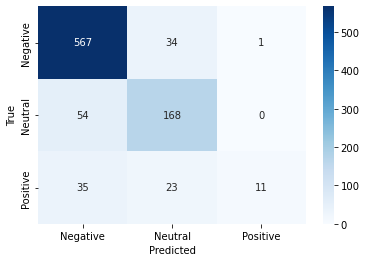

In [27]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
def confidence_scores(review_text):
    review_tfidf = vectorizer.transform([review_text])
    
    sentiment_labels = {1:'Positive', 2:'Negative', 3:'Neutral'}
    
    sentiment_probs = model.predict(review_tfidf.toarray())
    sentiment_class = sentiment_probs.argmax(axis=1)[0]
    
    sentiment_class += 1
    
    
    confidence = sentiment_probs[0][sentiment_class - 1]
    return sentiment_labels[sentiment_class], confidence

In [29]:
print(confidence_scores(testreview1))
print(confidence_scores(testreview2))
print(confidence_scores(testreview3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
('Positive', 0.9997217)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
('Negative', 0.7595466)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
('Positive', 0.7905306)
